In [1]:
# !pip install scikit-image

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-09-12 17:32:43.149952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-12 17:32:45.280277: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-09-12 17:32:45.280547: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-09-12 17:32:45.284811: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2024-09-12 17:32:45.597830: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


# Image Augmentation
* 학습데이터 부족을 해결하기 위해서 이미지에 변형을 가해 새로운 이미지를 만들어 주는 것

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

In [4]:
image = load_img("./catanddog/bird.jpg")
image_array = img_to_array(image)
image_array.shape

(703, 454, 3)

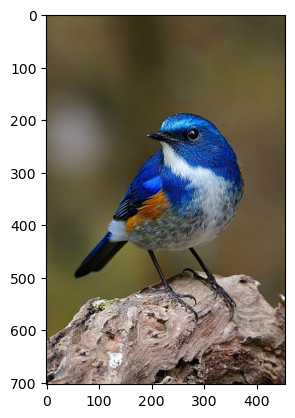

In [5]:
plt.imshow(image)
plt.show()

In [6]:
datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.3,
            height_shift_range=0.2,
            shear_range=0.6,
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
)

In [7]:
image_array.reshape((1,) + image_array.shape).shape

(1, 703, 454, 3)

In [8]:
image_array.shape

(703, 454, 3)

In [9]:
image_array = image_array.reshape((1,) + image_array.shape)

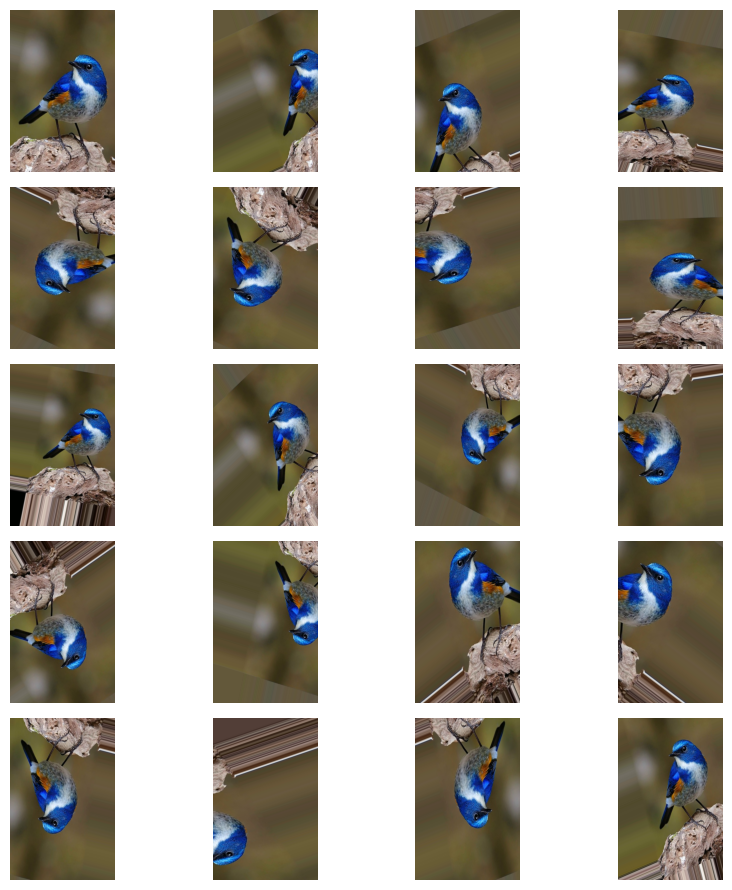

In [10]:
fig, axes = plt.subplots(5, 4, figsize=(9,9))
axes = axes.ravel()

for i, batch in enumerate(datagen.flow(image_array, batch_size=1)):
    if i >= 20:   # 20개 이미지 생성 후 종료
        break
    augmented_image = array_to_img(batch[0])
    axes[i].imshow(augmented_image)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# 전이학습 
* 사전에 훈련된 모델을 가지고 새로운 데이터를 넣어서 훈련하거나 결과를 출력

In [11]:
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
import tensorflow as tf

# GPU 디바이스 설정
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

In [12]:
base_model = ResNet50(include_top=True,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=None,
                        pooling=None,
                        classes=1000)

2024-09-12 17:32:49.946472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-12 17:32:49.948392: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon(TM) RX Vega 11 Graphics)
2024-09-12 17:32:50.114541: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-12 17:32:50.114619: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 15603 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


In [13]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [21]:
base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense_1 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 25,638,714
Trainable params: 2,002
Non-trainable params: 25,636,712
_________________________________________________________________


In [22]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
modelpath = "./model/Resnet50_catndog.keras"
checkpoint = ModelCheckpoint(filepath=modelpath, save_best_only=True)
earlystop = EarlyStopping(patience=10)

In [23]:
train_dir = "./catanddog/train/"
valid_dir = "./catanddog/validation/"
batch_size= 64
image_height = 224
image_width = 224

In [24]:
train = ImageDataGenerator(
            rescale=1.0/255,
            rotation_range=40,
            width_shift_range=0.3,
            height_shift_range=0.2,
            shear_range=0.6,
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
)

train_gen = train.flow_from_directory(train_dir, target_size=(image_height, image_width),
                                     color_mode='rgb',
                                     batch_size=batch_size,
                                     seed=7,
                                     shuffle=True,
                                     class_mode='categorical')

Found 385 images belonging to 2 classes.


In [25]:
valid = ImageDataGenerator(rescale=1.0/255)
valid_gen = valid.flow_from_directory(train_dir, target_size=(image_height, image_width),
                                     color_mode='rgb',
                                     batch_size=batch_size,
                                     seed=7,
                                     shuffle=True,
                                     class_mode='categorical')

Found 385 images belonging to 2 classes.


In [26]:
history=model.fit(train_gen, epochs=2000, validation_data=valid_gen, callbacks=[earlystop, checkpoint])

Epoch 1/2000


2024-09-12 17:35:12.085975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-12 17:35:12.866499: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-12 17:35:12.866609: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 15603 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


7/7 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.4519

2024-09-12 17:35:27.460636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-12 17:35:28.105499: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-12 17:35:28.105609: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 15603 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


7/7 [==============================] - 35s 4s/step - loss: 0.6933 - accuracy: 0.4519 - val_loss: 0.6931 - val_accuracy: 0.5195
Epoch 2/2000
7/7 [==============================] - 24s 3s/step - loss: 0.6932 - accuracy: 0.4961 - val_loss: 0.6932 - val_accuracy: 0.4779
Epoch 3/2000
7/7 [==============================] - 26s 4s/step - loss: 0.6931 - accuracy: 0.5403 - val_loss: 0.6930 - val_accuracy: 0.5273
Epoch 4/2000
7/7 [==============================] - 26s 4s/step - loss: 0.6929 - accuracy: 0.5273 - val_loss: 0.6929 - val_accuracy: 0.5273
Epoch 5/2000
7/7 [==============================] - 26s 4s/step - loss: 0.6928 - accuracy: 0.5273 - val_loss: 0.6928 - val_accuracy: 0.5273
Epoch 6/2000
7/7 [==============================] - 25s 4s/step - loss: 0.6928 - accuracy: 0.5273 - val_loss: 0.6928 - val_accuracy: 0.5273
Epoch 7/2000
7/7 [==============================] - 23s 3s/step - loss: 0.6928 - accuracy: 0.5273 - val_loss: 0.6928 - val_accuracy: 0.5273
Epoch 8/2000
7/7 [===============